In [38]:
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

import statsmodels.api as sm
import xgboost as xgb

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('feature_engineered_df.csv')

In [3]:
df.head()

,tmax,tmin,prcp,Total Energy Sales (MWh),Total Customers,Gasoline Price,Coal Production,Natural Gas (Dry) Production,Crude Oil Production,Natural Gas Plant Liquids Production,...,Total Renewable Energy Production_lag1,Total Renewable Energy Production_lag2,Total Renewable Energy Production_lag3,Total Renewable Energy Production_rolling_mean3,Total Renewable Energy Production_rolling_mean6,Total Renewable Energy Production_rolling_mean12,energy_consumption_renewable_interaction,energy_consumption_traditional_interaction,energy_consumption_industrial_interaction,Energy Consumption PCA Component
0,12.0,-6.0,0.01,2.233527e+09,87386416.0,1.114,1.759371,1.487280,1.099501,0.170481,...,NaN,NaN,NaN,NaN,NaN,NaN,1.060030e+09,1.008802e+10,1.498830e+11,712.139879
1,32.0,5.0,0.00,2.233527e+09,87386416.0,1.109,2.069239,1.665073,1.212863,0.192734,...,0.474599,NaN,NaN,NaN,NaN,NaN,1.184873e+09,1.148012e+10,1.513867e+11,232.281800
2,69.0,28.0,0.00,2.233527e+09,87386416.0,1.128,1.887272,1.582420,1.150506,0.187750,...,0.530494,0.474599,NaN,0.506973,NaN,NaN,1.152113e+09,1.073868e+10,1.523055e+11,-410.263827
3,58.0,32.0,0.00,2.233527e+09,87386416.0,1.143,1.771421,1.637923,1.202537,0.197688,...,0.515827,0.530494,0.474599,0.513624,NaN,NaN,1.104591e+09,1.074230e+10,1.530270e+11,-698.389313
4,77.0,50.0,0.01,2.233527e+09,87386416.0,1.169,1.860760,1.562982,1.150243,0.193789,...,0.494550,0.515827,0.530494,0.502604,NaN,NaN,1.111032e+09,1.064895e+10,1.540258e+11,-711.749294


In [4]:
df.columns

Index(['tmax', 'tmin', 'prcp', 'Total Energy Sales (MWh)', 'Total Customers',
       'Gasoline Price', 'Coal Production', 'Natural Gas (Dry) Production',
       'Crude Oil Production', 'Natural Gas Plant Liquids Production',
       'Total Fossil Fuels Production', 'Nuclear Electric Power Production',
       'Hydroelectric Power Production', 'Geothermal Energy Production',
       'Solar Energy Production', 'Wind Energy Production',
       'Biomass Energy Production', 'Total Renewable Energy Production',
       'Total Primary Energy Production', 'Electricity Price',
       'Petroleum and Coal', 'CPI', 'Working Age Population',
       'Unemployment rate', 'Personal savings rate', 'M2 money supply',
       'Personal consumption expenditures (PCE) price index excluding food and energy',
       'Personal consumption expenditures', 'Real effective exchange rate',
       '3-Month Treasury Bill: Secondary Market Rate',
       'Federal Funds Rate - Upper Bound', 'Consumer Confidence Index',
    

## Removing redundant columns

In [5]:
df.drop(['Brent Price', 'CPI'], axis=1, inplace=True)

## Create DF to use for energy consumption prediction

In [6]:
remove_cols_cons = ['Coal Production', 'Natural Gas (Dry) Production',
       'Crude Oil Production', 'Natural Gas Plant Liquids Production',
       'Total Fossil Fuels Production', 'Nuclear Electric Power Production',
       'Hydroelectric Power Production', 'Geothermal Energy Production',
       'Solar Energy Production', 'Wind Energy Production',
       'Biomass Energy Production', 'Total Renewable Energy Production',
       'Total Primary Energy Production', 'Total Renewable Energy Production_lag1',
       'Total Renewable Energy Production_lag2',
       'Total Renewable Energy Production_lag3',
       'Total Renewable Energy Production_rolling_mean3',
       'Total Renewable Energy Production_rolling_mean6',
       'Total Renewable Energy Production_rolling_mean12']
energy_consumption_df = df.drop(remove_cols_cons, axis=1)

## Create DF to use for renewable energy generation prediction

In [7]:
remove_cols_renew = ['Coal Production', 'Natural Gas (Dry) Production', 'Crude Oil Production', 
                     'Natural Gas Plant Liquids Production', 'Total Fossil Fuels Production', 
                     'Nuclear Electric Power Production', 'Hydroelectric Power Production', 
                     'Geothermal Energy Production', 'Solar Energy Production', 
                     'Wind Energy Production', 'Biomass Energy Production', 'Total Primary Energy Production',   
                     'Total Energy Sales (MWh)_lag1', 'Total Energy Sales (MWh)_lag2', 'Total Energy Sales (MWh)_lag3', 
                     'Total Energy Sales (MWh)_rolling_mean3', 'Total Energy Sales (MWh)_rolling_mean6', 'Total Energy Sales (MWh)_rolling_mean12']
renewable_df = df.drop(remove_cols_renew, axis=1)

## Run models for Energy Consumption forecasting

### SVM for prediction Total Energy Sale (MWh)

In [8]:
# Create dummy variables for season and month
data = pd.get_dummies(energy_consumption_df, columns=['season', 'month']).dropna()

# Separate features and target variable
X = data.drop(['Total Energy Sales (MWh)', 'DATE', 'Energy Consumption PCA Component'], axis=1)
y = data['Total Energy Sales (MWh)']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define k-fold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Define SVM model
svm_model = SVR()

# Define hyperparameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto'] + [0.01, 0.1, 1, 10]
}

# Perform grid search with k-fold cross-validation
svm_grid_search = GridSearchCV(svm_model, param_grid, cv=kf, scoring='neg_root_mean_squared_error')
svm_grid_search.fit(X_scaled, y)

# Print best hyperparameters
print("Best hyperparameters for SVM:", svm_grid_search.best_params_)

# Compute mean RMSE across folds for SVM with best hyperparameters
svm_rmse_list = []
for train_index, test_index in kf.split(X_scaled):
    # Split data into training and test sets
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Train SVM model with best hyperparameters
    svm_model = SVR(**svm_grid_search.best_params_)
    svm_model.fit(X_train, y_train)
    
    # Evaluate model on test set and store RMSE
    y_pred = svm_model.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    svm_rmse_list.append(rmse)

# Compute mean RMSE across folds for SVM with best hyperparameters
svm_mean_rmse = sum(svm_rmse_list) / len(svm_rmse_list)
print("SVM RMSE with best hyperparameters:", svm_mean_rmse)

Best hyperparameters for SVM: {'C': 100, 'gamma': 0.01}
SVM RMSE with best hyperparameters: 117895832.70190868


### SVM for predicting Energy Consumption PCA Component

In [9]:
# Separate features and target variable
X = data.drop(['Total Energy Sales (MWh)', 'DATE', 'Energy Consumption PCA Component'], axis=1)
y = data['Energy Consumption PCA Component']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define k-fold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Define SVM model
svm_model = SVR()

# Define hyperparameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto'] + [0.01, 0.1, 1, 10]
}

# Perform grid search with k-fold cross-validation
svm_grid_search = GridSearchCV(svm_model, param_grid, cv=kf, scoring='neg_root_mean_squared_error')
svm_grid_search.fit(X_scaled, y)

# Print best hyperparameters
print("Best hyperparameters for SVM:", svm_grid_search.best_params_)

# Compute mean RMSE across folds for SVM with best hyperparameters
svm_rmse_list = []
for train_index, test_index in kf.split(X_scaled):
    # Split data into training and test sets
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Train SVM model with best hyperparameters
    svm_model = SVR(**svm_grid_search.best_params_)
    svm_model.fit(X_train, y_train)
    
    # Evaluate model on test set and store RMSE
    y_pred = svm_model.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    svm_rmse_list.append(rmse)

# Compute mean RMSE across folds for SVM with best hyperparameters
svm_mean_rmse = sum(svm_rmse_list) / len(svm_rmse_list)
print("SVM RMSE with best hyperparameters:", svm_mean_rmse)

Best hyperparameters for SVM: {'C': 100, 'gamma': 0.01}
SVM RMSE with best hyperparameters: 259.7629261260897


## Decision Tree for Energy Consumption Prediction

### Decision Tree for predicting Total Energy Sales (MWh)

In [10]:
# Separate features and target variable
X = data.drop(['Total Energy Sales (MWh)', 'DATE', 'Energy Consumption PCA Component'], axis=1)
y = data['Total Energy Sales (MWh)']

# Define k-fold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Define Decision Tree Regressor model
dt_model = DecisionTreeRegressor(random_state=42)

# Define hyperparameter grid
param_grid = {
    'max_depth': [2, 4, 6, 8, 10],
    'min_samples_split': [2, 4, 6, 8, 10],
    'min_samples_leaf': [1, 2, 3, 4, 5],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Perform grid search with k-fold cross-validation
dt_grid_search = GridSearchCV(dt_model, param_grid, cv=kf, scoring='neg_root_mean_squared_error')
dt_grid_search.fit(X, y)

# Print best hyperparameters
print("Best hyperparameters for Decision Tree Regressor:", dt_grid_search.best_params_)

# Compute mean RMSE across folds for Decision Tree Regressor with best hyperparameters
dt_rmse_list = []
for train_index, test_index in kf.split(X):
    # Split data into training and test sets
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Train Decision Tree Regressor model with best hyperparameters
    dt_model = DecisionTreeRegressor(**dt_grid_search.best_params_, random_state=42)
    dt_model.fit(X_train, y_train)
    
    # Evaluate model on test set and store RMSE
    y_pred = dt_model.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    dt_rmse_list.append(rmse)

# Compute mean RMSE across folds for Decision Tree Regressor with best hyperparameters
dt_mean_rmse = sum(dt_rmse_list) / len(dt_rmse_list)
print("Decision Tree Regressor RMSE with best hyperparameters:", dt_mean_rmse)

Best hyperparameters for Decision Tree Regressor: {'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 6}
Decision Tree Regressor RMSE with best hyperparameters: 11813864.572230961


### Decision Tree for predicting Energy Consumption PCA Component

In [11]:
# Separate features and target variable
X = data.drop(['Total Energy Sales (MWh)', 'DATE', 'Energy Consumption PCA Component'], axis=1)
y = data['Energy Consumption PCA Component']

# Define k-fold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Define Decision Tree Regressor model
dt_model = DecisionTreeRegressor(random_state=42)

# Define hyperparameter grid
param_grid = {
    'max_depth': [2, 4, 6, 8, 10],
    'min_samples_split': [2, 4, 6, 8, 10],
    'min_samples_leaf': [1, 2, 3, 4, 5],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Perform grid search with k-fold cross-validation
dt_grid_search = GridSearchCV(dt_model, param_grid, cv=kf, scoring='neg_root_mean_squared_error')
dt_grid_search.fit(X, y)

# Print best hyperparameters
print("Best hyperparameters for Decision Tree Regressor:", dt_grid_search.best_params_)

# Compute mean RMSE across folds for Decision Tree Regressor with best hyperparameters
dt_rmse_list = []
for train_index, test_index in kf.split(X):
    # Split data into training and test sets
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Train Decision Tree Regressor model with best hyperparameters
    dt_model = DecisionTreeRegressor(**dt_grid_search.best_params_, random_state=42)
    dt_model.fit(X_train, y_train)
    
    # Evaluate model on test set and store RMSE
    y_pred = dt_model.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    dt_rmse_list.append(rmse)

# Compute mean RMSE across folds for Decision Tree Regressor with best hyperparameters
dt_mean_rmse = sum(dt_rmse_list) / len(dt_rmse_list)
print("Decision Tree Regressor RMSE with best hyperparameters:", dt_mean_rmse)

Best hyperparameters for Decision Tree Regressor: {'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 5, 'min_samples_split': 2}
Decision Tree Regressor RMSE with best hyperparameters: 169.4143367416745


## Random Forest for Energy Consumption Prediction

### Random Forest for predicting Total Energy Sales (MWh)

In [12]:
# Separate features and target variable
X = data.drop(['Total Energy Sales (MWh)', 'DATE', 'Energy Consumption PCA Component'], axis=1)
y = data['Total Energy Sales (MWh)']


# Define k-fold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Define Random Forest Regressor model
rf_model = RandomForestRegressor(random_state=42)

# Define hyperparameter grid
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [2, 4, 6, 8, 10],
    'min_samples_split': [2, 4, 6, 8, 10],
    'min_samples_leaf': [1, 2, 3, 4, 5],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Perform grid search with k-fold cross-validation
rf_grid_search = GridSearchCV(rf_model, param_grid, cv=kf, scoring='neg_root_mean_squared_error')
rf_grid_search.fit(X, y)

# Print best hyperparameters
print("Best hyperparameters for Random Forest Regressor:", rf_grid_search.best_params_)

# Compute mean RMSE across folds for Random Forest Regressor with best hyperparameters
rf_rmse_list = []
for train_index, test_index in kf.split(X):
    # Split data into training and test sets
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Train Random Forest Regressor model with best hyperparameters
    rf_model = RandomForestRegressor(**rf_grid_search.best_params_, random_state=42)
    rf_model.fit(X_train, y_train)
    
    # Evaluate model on test set and store RMSE
    y_pred = rf_model.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    rf_rmse_list.append(rmse)

# Compute mean RMSE across folds for Random Forest Regressor with best hyperparameters
rf_mean_rmse = sum(rf_rmse_list) / len(rf_rmse_list)
print("Random Forest Regressor RMSE with best hyperparameters:", rf_mean_rmse)


Best hyperparameters for Random Forest Regressor: {'max_depth': 8, 'max_features': 'auto', 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 200}
Random Forest Regressor RMSE with best hyperparameters: 11597988.8205847


### Random Forest for predicting Energy Consumption PCA Component

In [13]:
# Separate features and target variable
X = data.drop(['Total Energy Sales (MWh)', 'DATE', 'Energy Consumption PCA Component'], axis=1)
y = data['Energy Consumption PCA Component']


# Define k-fold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Define Random Forest Regressor model
rf_model = RandomForestRegressor(random_state=42)

# Define hyperparameter grid
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [2, 4, 6, 8, 10],
    'min_samples_split': [2, 4, 6, 8, 10],
    'min_samples_leaf': [1, 2, 3, 4, 5],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Perform grid search with k-fold cross-validation
rf_grid_search = GridSearchCV(rf_model, param_grid, cv=kf, scoring='neg_root_mean_squared_error')
rf_grid_search.fit(X, y)

# Print best hyperparameters
print("Best hyperparameters for Random Forest Regressor:", rf_grid_search.best_params_)

# Compute mean RMSE across folds for Random Forest Regressor with best hyperparameters
rf_rmse_list = []
for train_index, test_index in kf.split(X):
    # Split data into training and test sets
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Train Random Forest Regressor model with best hyperparameters
    rf_model = RandomForestRegressor(**rf_grid_search.best_params_, random_state=42)
    rf_model.fit(X_train, y_train)
    
    # Evaluate model on test set and store RMSE
    y_pred = rf_model.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    rf_rmse_list.append(rmse)

# Compute mean RMSE across folds for Random Forest Regressor with best hyperparameters
rf_mean_rmse = sum(rf_rmse_list) / len(rf_rmse_list)
print("Random Forest Regressor RMSE with best hyperparameters:", rf_mean_rmse)

Best hyperparameters for Random Forest Regressor: {'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 200}
Random Forest Regressor RMSE with best hyperparameters: 154.13689189458336


#### Feature Importance for the Random Forest Model

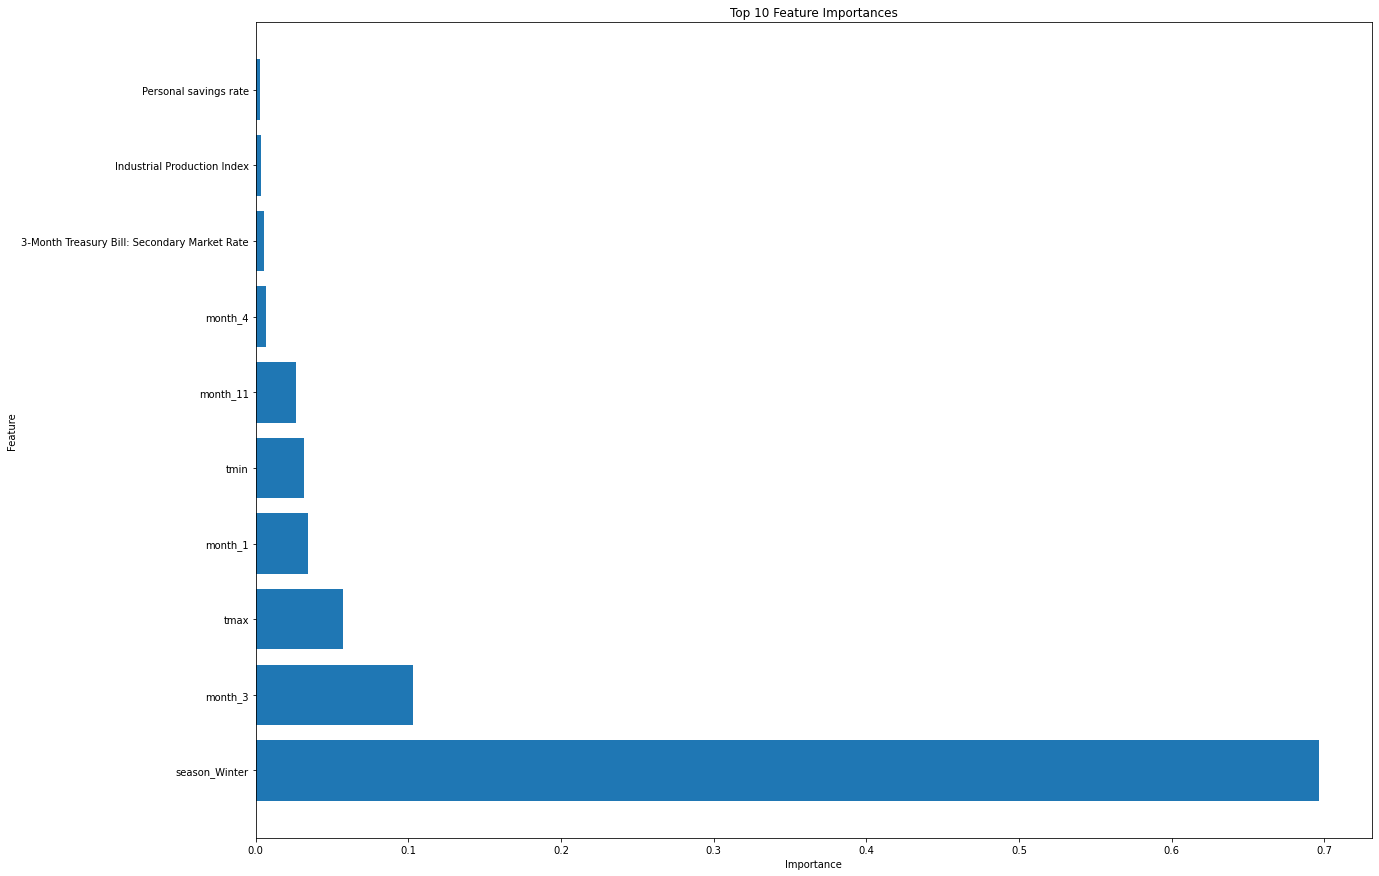

In [14]:
# Compute feature importances
importances = rf_model.feature_importances_

# Sort feature importances in descending order
sorted_indices = importances.argsort()[::-1]

# Sort feature names in descending order
sorted_feature_names = X.columns[sorted_indices]

plt.figure(figsize=(20,15))

# Get the top 10 feature importances
top_importances = importances[sorted_indices][:10]
top_feature_names = sorted_feature_names[:10]

# Create horizontal bar chart
plt.barh(range(len(top_importances)), top_importances)
plt.yticks(range(len(top_importances)), top_feature_names)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 10 Feature Importances')
plt.show()

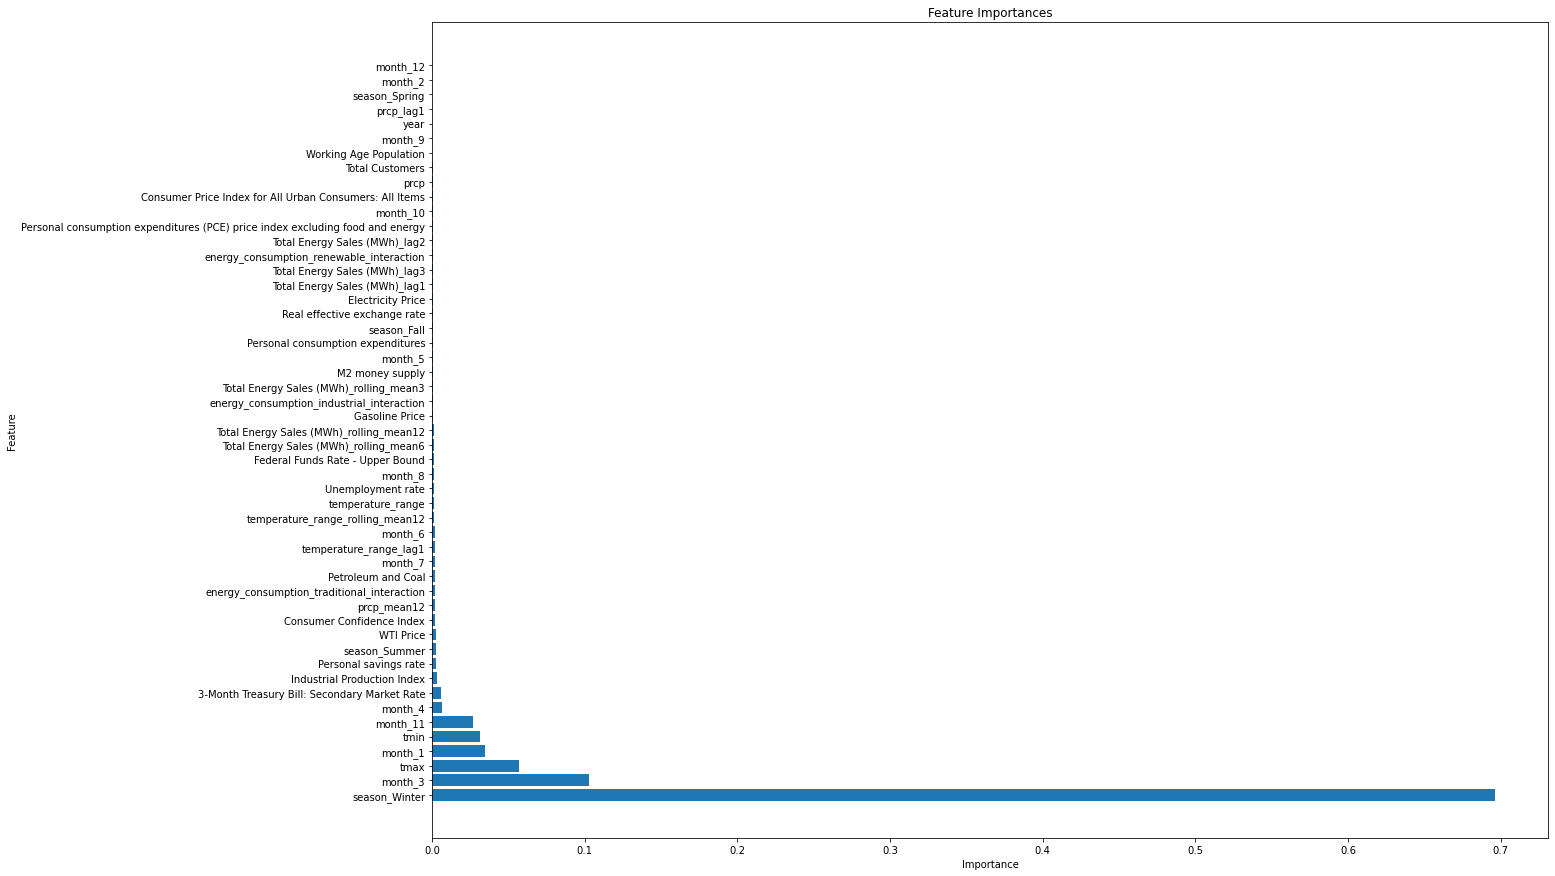

In [15]:
# Compute feature importances
importances = rf_model.feature_importances_

# Sort feature importances in descending order
sorted_indices = importances.argsort()[::-1]

# Sort feature names in descending order
sorted_feature_names = X.columns[sorted_indices]

plt.figure(figsize=(20,15))

# Create horizontal bar chart
plt.barh(range(len(importances)), importances[sorted_indices])
plt.yticks(range(len(importances)), sorted_feature_names)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.show()

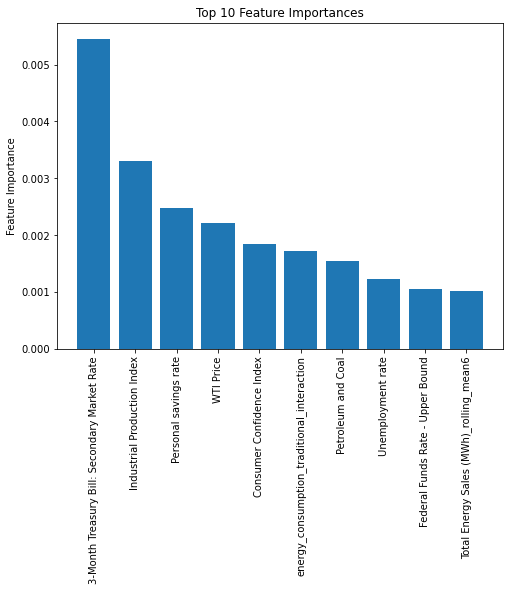

In [16]:
# Create a list of columns to drop
drop_cols = ['tmax', 'tmin', 'temperature_range', 'temperature_range_lag1', 'temperature_range_rolling_mean12',
             'prcp', 'prcp_lag1', 'prcp_mean12', 'season_Fall', 'season_Spring',
             'season_Summer', 'season_Winter', 'month_1', 'month_2', 'month_3',
             'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9',
             'month_10', 'month_11', 'month_12']

# Drop the unwanted columns from the dataframe
X_filtered = X.drop(drop_cols, axis=1)

# Compute feature importances
importances = rf_model.feature_importances_

# Sort feature importances in descending order
sorted_indices = importances.argsort()[::-1]
sorted_importances = [importances[i] for i in sorted_indices if X.columns[i] not in drop_cols][:10]

# Create a bar plot of the top 10 feature importances
fig, ax = plt.subplots(figsize=(8,6))
ax.bar(range(len(sorted_importances)), sorted_importances)
ax.set_xticks(range(len(sorted_importances)))
ax.set_xticklabels([X.columns[i] for i in sorted_indices if X.columns[i] not in drop_cols][:10], rotation=90)
ax.set_ylabel('Feature Importance')
ax.set_title('Top 10 Feature Importances')
plt.show()

## Predicting Total Renewable Energy Production

### Predicting Total Renewable Energy Production with a GLM model with F distribution

In [39]:
# Load data into pandas DataFrame
data = pd.get_dummies(renewable_df, columns=['season', 'month']).dropna()

# Separate features and target variable
X = data.drop(['Total Renewable Energy Production', 'DATE'], axis=1)
y = data['Total Renewable Energy Production']

class GLMRegressor():
    def __init__(self, alpha=0.5, fit_intercept=True):
        self.alpha = alpha
        self.fit_intercept = fit_intercept
        self.model_ = None

    def fit(self, X, y):
        X = sm.add_constant(X)
        self.model_ = sm.GLM(y, X, family=sm.families.Tweedie(var_power=self.alpha))
        self.results_ = self.model_.fit()
        return self

    def predict(self, X):
        X = sm.add_constant(X)
        return self.results_.predict(X)

    def get_params(self, deep=True):
        return {'alpha': self.alpha, 'fit_intercept': self.fit_intercept}

    def set_params(self, **params):
        if 'alpha' in params:
            self.alpha = params['alpha']
        if 'fit_intercept' in params:
            self.fit_intercept = params['fit_intercept']
        return self
    
glm_model = GLMRegressor()

# Perform hyperparameter tuning and k-fold cross-validation
grid_search = GridSearchCV(glm_model, param_grid, cv=kf, scoring='neg_mean_squared_error')
grid_search.fit(sm.add_constant(np.asarray(X)), y)

# Get best hyperparameters and corresponding model
best_params = grid_search.best_params_
best_model = GLMRegressor(**best_params)
best_model.fit(sm.add_constant(np.asarray(X)), y)

# Compute RMSE using k-fold cross-validation
mse_scores = -1 * cross_val_score(best_model, sm.add_constant(X), y, cv=kf, scoring='neg_mean_squared_error')
rmse_scores = np.sqrt(mse_scores)
mean_rmse = np.mean(rmse_scores)
std_rmse = np.std(rmse_scores)

# Print best hyperparameters and mean and standard deviation of RMSE
print("Best hyperparameters:", best_params)
print("Mean RMSE for GLM with Tweedie distribution:", mean_rmse)
print("Standard deviation of RMSE for GLM with Tweedie distribution:", std_rmse)


Best hyperparameters: {'alpha': 0.0001}
Mean RMSE for GLM with Tweedie distribution: 0.011086919589843239
Standard deviation of RMSE for GLM with Tweedie distribution: 0.0013274915053902733


### Predicting Total Renewable Energy Production using RandomForest

In [ ]:
# Separate features and target variable
X = data.drop(['Total Renewable Energy Production', 'DATE'], axis=1)
y = data['Total Renewable Energy Production']

# Define k-fold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Define Random Forest Regressor model
rf_model = RandomForestRegressor(random_state=42)

# Define hyperparameter grid
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [2, 4, 6, 8, 10],
    'min_samples_split': [2, 4, 6, 8, 10],
    'min_samples_leaf': [1, 2, 3, 4, 5],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Perform grid search with k-fold cross-validation
rf_grid_search = GridSearchCV(rf_model, param_grid, cv=kf, scoring='neg_root_mean_squared_error')
rf_grid_search.fit(X, y)

# Print best hyperparameters
print("Best hyperparameters for Random Forest Regressor:", rf_grid_search.best_params_)

# Compute mean RMSE across folds for Random Forest Regressor with best hyperparameters
rf_rmse_list = []
for train_index, test_index in kf.split(X):
    # Split data into training and test sets
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Train Random Forest Regressor model with best hyperparameters
    rf_model = RandomForestRegressor(**rf_grid_search.best_params_, random_state=42)
    rf_model.fit(X_train, y_train)
    
    # Evaluate model on test set and store RMSE
    y_pred = rf_model.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    rf_rmse_list.append(rmse)

# Compute mean RMSE across folds for Random Forest Regressor with best hyperparameters
rf_mean_rmse = sum(rf_rmse_list) / len(rf_rmse_list)
print("Random Forest Regressor RMSE with best hyperparameters:", rf_mean_rmse)

### Visualizing the feature importance scores for the GLM model

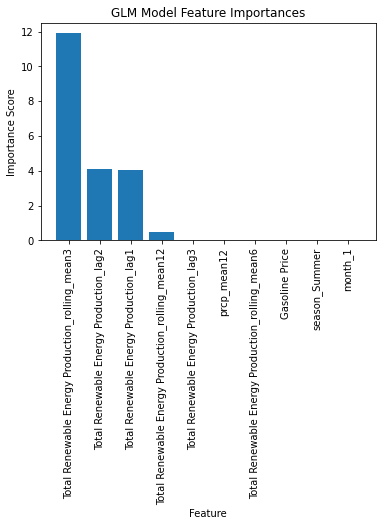

In [69]:
feature_df = pd.DataFrame({'Features': X.columns, 'Importance':best_model.results_.params[1:].abs()})
temp_df = feature_df.sort_values(by='Importance', ascending=False).head(10)

# Create a bar plot of feature importances
plt.bar(range(len(temp_df)), temp_df['Importance'])
plt.xticks(range(len(temp_df)), temp_df['Features'], rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance Score')
plt.title('GLM Model Feature Importances')
plt.show()

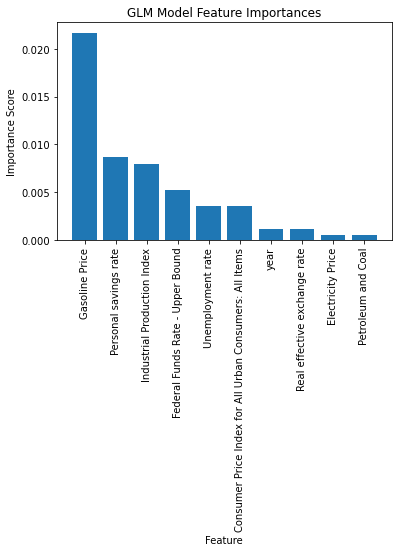

In [67]:
drop_cols = ['tmax', 'tmin', 'temperature_range', 'temperature_range_lag1', 
             'temperature_range_rolling_mean12',              
             'prcp', 'prcp_lag1', 'prcp_mean12', 'season_Fall', 'season_Spring',
             'season_Summer', 'season_Winter', 'month_1', 'month_2', 'month_3',
             'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9',
             'month_10', 'month_11', 'month_12', 'Total Renewable Energy Production_lag1',
             'Total Renewable Energy Production_lag2',
             'Total Renewable Energy Production_lag3',
             'Total Renewable Energy Production_rolling_mean3',
             'Total Renewable Energy Production_rolling_mean6',
             'Total Renewable Energy Production_rolling_mean12']


feature_df = pd.DataFrame({'Features': X.columns, 'Importance':best_model.results_.params[1:].abs()})
temp_df = feature_df.sort_values(by='Importance', ascending=False)

temp_df = temp_df[~temp_df['Features'].isin(drop_cols)].head(10)

# Create a bar plot of feature importances
plt.bar(range(len(temp_df)), temp_df['Importance'])
plt.xticks(range(len(temp_df)), temp_df['Features'], rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance Score')
plt.title('GLM Model Feature Importances')
plt.show()

In [72]:
feature_df = pd.DataFrame({'Features': X.columns, 'Importance':best_model.results_.params[1:]})

In [73]:
feature_df

,Features,Importance
x1,tmax,-8.353228e-05
x2,tmin,3.091467e-04
x3,prcp,5.870809e-03
x4,Total Energy Sales (MWh),4.326652e-10
x5,Total Customers,-4.441458e-09
x6,Gasoline Price,2.169715e-02
x7,Electricity Price,5.333262e-04
x8,Petroleum and Coal,-4.614869e-04
x9,Working Age Population,-7.124378e-10
x10,Unemployment rate,3.588605e-03
